# MiniProject 2: Multi-Class Logistic Regression and Gradient Descent

In [1]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import math

# Part 1: Softmax Regression with Improved Gradient Descent

## Improved Gradient Descent

In [2]:
def create_mini_batches(x, y, batch_size): 
    mini_batches = []
    data = np.hstack((x, y[:,None]))
    np.random.shuffle(data) 
    n_minibatches = math.ceil(data.shape[0] // batch_size) 
    data = np.array_split(data, n_minibatches)
    mini_batches = []
    for batch_data in data:
        x_mini = batch_data[:, :-1]
        y_mini = batch_data[:, -1]
        mini_batches.append((x_mini, y_mini))
    return mini_batches

In [3]:
class ImprovedGradientDescent:
    def __init__(self, learning_rate=0.1, max_iters=1e4, epsilon=1e-8, record_history=False, momentum=0.5, batch_size=20):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        self.momentum = momentum
        self.batch_size = batch_size
        if record_history:
            self.w_history = []                         #to store the weight history for visualization
            
    def run(self, gradient_fn, x, y, w, x_vali=None, y_vali=None):
        if x_vali is None:
            x_vali = x
        if y_vali is None:
            y_vali = y
        grad = np.inf
        grad_old = 0
        t = 1
        accuracy = 0
        accuracy_best = 0
        num_worse = 0
        w_best = w
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            mini_batches = create_mini_batches(x, y, self.batch_size) 
            for mini_batch in mini_batches: 
                x_mini, y_mini = mini_batch
                grad = self.momentum*grad_old + (1-self.momentum)*gradient_fn(x_mini, y_mini, w)  # compute the gradient with present weight and momentum
                w = w - self.learning_rate * grad       # weight update step
                grad_old = grad                         # the current gradient is the old gradient for the next iteration
            if self.record_history:
                self.w_history.append(w)
            accuracy = (to_classlabel(softmax(np.dot(x_vali, w))) == y_vali).astype(float).mean()
            if accuracy > accuracy_best:
                num_worse = 0
                accuracy_best = accuracy
                w_best = w
            else:
                num_worse += 1
            if num_worse >= 20:
                break
            t += 1
        w = w_best
        return w

## Softmax Regression

In [4]:
def softmax(z):                                        # define the softmax function
            z -= np.max(z)                             # for numerical stability
            return (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
    
def one_hot(y, C):                                        # define the one-hot encoding for labels
            return (np.arange(C) == y[:, None]).astype(float)

In [5]:
class SoftmaxRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
    
    def fit(self, x, y, optimizer, x_vali=None, y_vali=None):
        if x_vali is None:
            x_vali = x
        if y_vali is None:
            y_vali = y
        if x_vali.ndim == 1:
            x_vali = x_vali[:, None]
        if self.add_bias:
            N = x_vali.shape[0]
            x_vali = np.column_stack([x_vali,np.ones(N)])
        
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        C = np.max(y) + 1
        def gradient(x, y, w):                          # define the gradient function
            yh = softmax(np.dot(x, w))                  # predictions
            y = one_hot(y, C)                              # labels with one-hot encoding
            N, D = x.shape
            grad = np.dot(x.T, (yh - y))/N              # divide by N because cost is mean over N points
            return grad
        w0 = np.zeros((D, np.max(y) + 1))               # initialize the weights to 0, note that the dimension is D*C
        self.w = optimizer.run(gradient, x, y, w0, x_vali, y_vali)      # run the optimizer to get the optimal weights
        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        yh = softmax(np.dot(x,self.w))                  #predict output
        return yh

In [6]:
def to_classlabel(z):                                   # convert the output class probabilities to be class labels
    return z.argmax(axis=1)

# Part 2: Performance Analysis

In [7]:
from sklearn import datasets
from sklearn.datasets import fetch_openml
from sklearn import neighbors
import time

In [8]:
digits = datasets.load_digits()

In [9]:
iris = fetch_openml(name='iris', version=1)

#convert the labels to 0,1,2 for easy one-hot encoding
for i in range(0, len(iris['target'])):
    if iris['target'][i] == 'Iris-setosa':
        iris['target'][i] = 0
    elif iris['target'][i] == 'Iris-versicolor':
        iris['target'][i] = 1
    elif iris['target'][i] == 'Iris-virginica':
        iris['target'][i] = 2        
iris['target']=iris['target'].astype(int)

## 5-fold Cross-validation

In [10]:
# K fold Cross_Validation Split
def Kcross_validation_test(dataset, folds=5,regression_method="SoftmaxImproved", feature = "validation_performance",learning_rate=0.1,momentum=0.5,batch_size=20, k=1):
    data = np.hstack((dataset['data'],dataset['target'][:,None]))
    np.random.shuffle(data)
    if folds>data.shape[0]: # number of fold at most is the size of data
        folds = data.shape[0]
    dataset_split = np.array_split(data,folds)
    
    total_accuracy=0
    for i in range(len(dataset_split)):
        dataset_copy = dataset_split.copy()
        validation = dataset_copy[i]
        del dataset_copy[i:i+1]
        train = dataset_copy[0]
        j = 1
        while j in range(len(dataset_copy)):
            train = np.append(train,dataset_copy[j],axis=0);
            j = j+1
        
        train_x = train[:,:-1]
        train_y = train[:,-1].astype(int)
        validation_x = validation[:,:-1]
        validation_y = validation[:,-1].astype(int)
        
        if feature == "validation_performance":
            if regression_method=="SoftmaxImproved":
                validation_yh = SoftmaxRegression().fit(train_x,train_y, ImprovedGradientDescent(learning_rate=learning_rate,momentum=momentum, batch_size=batch_size), validation_x, validation_y).predict(validation_x)
                total_accuracy += (to_classlabel(validation_yh) == validation_y).astype(float).mean()
            elif regression_method=="KNN":
                validation_yh = neighbors.KNeighborsClassifier(n_neighbors=k).fit(train_x, train_y).predict(validation_x)
                total_accuracy += (validation_yh == validation_y).astype(float).mean()
            else:
                print("Not a regression_method, please input SoftmaxImproved or KNN")
        elif feature == "training_performance":
            if regression_method=="SoftmaxImproved":
                train_yh = SoftmaxRegression().fit(train_x,train_y, ImprovedGradientDescent(learning_rate=learning_rate,momentum=momentum, batch_size=batch_size), validation_x, validation_y).predict(train_x)
                total_accuracy += (to_classlabel(train_yh) == train_y).astype(float).mean()
            elif regression_method=="KNN":
                train_yh = neighbors.KNeighborsClassifier(n_neighbors=k).fit(train_x, train_y).predict(train_x)
                total_accuracy += (train_yh == train_y).astype(float).mean()
            else:
                print("Not a regression_method, please input SoftmaxImproved or KNN")
        elif feature == "training_time":
            if regression_method=="SoftmaxImproved":
                start = time.time()
                train_yh = SoftmaxRegression().fit(train_x,train_y, ImprovedGradientDescent(learning_rate=learning_rate,momentum=momentum, batch_size=batch_size), validation_x, validation_y).predict(train_x)
                stop = time.time()
                total_accuracy += (stop - start) # it's training time, the variable name is to simplify the return
            elif regression_method=="KNN":
                start = time.time()
                train_yh = neighbors.KNeighborsClassifier(n_neighbors=k).fit(train_x, train_y).predict(train_x)
                stop = time.time()
                total_accuracy += (stop - start) # it's training time, the variable name is to simplify the return
            else:
                print("Not a regression_method, please input SoftmaxImproved or KNN")
        else:
            print("Not a feature, please input validation_performance, training_performance, or training_time")
    return total_accuracy/len(dataset_split)

## Grid Search for Optimal Hyperparameters

In [11]:
def generate_hyperparameter(low=0,high=1,scale=10):
    inc = (high-low)/scale
    hyperparameter_list=[]
    while low <= high:
        hyperparameter_list.append(low)
        low += inc
    return hyperparameter_list

def generate_hyperparameter_grid():
    learning_rate = generate_hyperparameter(low=0, high = 1, scale = 10)
    batch_size = generate_hyperparameter(low = 1, high = 101, scale = 10)
    momentum = generate_hyperparameter(low = 0, high = 1, scale = 10)
    
    import itertools
    hyperparameters = (learning_rate,batch_size,momentum)
    return list(itertools.product(*hyperparameters))

In [12]:
def grid_search(dataset):
    hyperparameter_grid = generate_hyperparameter_grid()

    optimal_accuracy = 0
    optimal_parameters = hyperparameter_grid[0]
    for parameters in hyperparameter_grid:
        acc = Kcross_validation_test(dataset,folds=5,regression_method="SoftmaxImproved",learning_rate=parameters[0], batch_size=parameters[1], momentum=parameters[2])
        if acc > optimal_accuracy:
            optimal_parameters = parameters
            optimal_accuracy = acc
        
    print("The optimal accuracy of improved softmax regression is " +str(optimal_accuracy) + " with learning rate = " + str(optimal_parameters[0]) + 
                      ", batch_size = " + str(optimal_parameters[1]) + ", and momentum =  " + str(optimal_parameters[2]) +".")
    return optimal_parameters

### Optimal parameters for digits dataset

In [11]:
optimal_parameters_digits = grid_search(digits)

The optimal accuracy of improved softmax regression is 0.9749659548127514 with learning rate = 0.4, batch_size = 21.0, and momentum =  0.7999999999999999.


### Optimal parameters for iris dataset

In [13]:
optimal_parameters_iris = grid_search(iris)

The optimal accuracy of improved softmax regression is 1.0 with learning rate = 0.6, batch_size = 31.0, and momentum =  0.7999999999999999.


## Performance vs. Hyperparameters

In [13]:
import matplotlib.pyplot as plt
def plot_hyper(dataset, hyperparameter=None,feature = "validation_performance", low = 0, high = 50,scale = 10, learning_rate=0.1,momentum=0.5,batch_size=20):
    if hyperparameter == "k":
        inc = 1
    elif hyperparameter == "batch_size":
        inc = (high - low)//scale
    else:
        inc = (high - low)/scale
    
    hyperparameter_values =list()
    accuracy=list()
    optium_hyper_value = high
    optium_accuracy = 0
    while low <= high:
        acc = 0
        if hyperparameter == "learning_rate":
            acc = Kcross_validation_test(dataset=dataset,folds=5,regression_method ="SoftmaxImproved",feature = feature, learning_rate=low, momentum=momentum, batch_size=batch_size)
        elif hyperparameter == "momentum":
            acc = Kcross_validation_test(dataset=dataset,folds=5,regression_method ="SoftmaxImproved",feature = feature, learning_rate=learning_rate, momentum=low, batch_size=batch_size)
        elif hyperparameter == "batch_size":
            acc = Kcross_validation_test(dataset=dataset,folds=5,regression_method ="SoftmaxImproved",feature = feature, learning_rate=learning_rate, momentum=momentum, batch_size=low)
        elif hyperparameter == "k":
            acc = Kcross_validation_test(dataset=dataset,folds=5,regression_method ="KNN",k=low)
        else:
            print("Not a hypermater")

        if acc > optium_accuracy : 
            optium_hyper_value = low
            optium_accuracy = acc

        hyperparameter_values.append(low)
        accuracy.append(acc)
        low += inc

    plt.plot(hyperparameter_values,accuracy, lw = 2, c="r")
    plt.title(feature + ' on different ' + hyperparameter)
    plt.xlabel(hyperparameter)
    plt.ylabel(feature)
    plt.show()
    
    if feature is not "training_time":
        print("The optimal value for " + hyperparameter + " is " + str(optium_hyper_value) +" with " + feature + " " + str(optium_accuracy))

### Performance vs. Hyperparameters for digits dataset

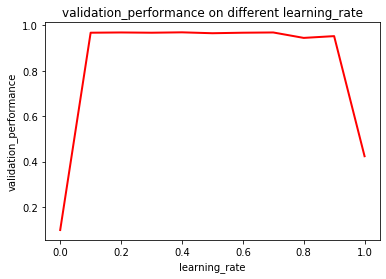

The optimal value for learning_rate is 0.4 with validation_performance 0.9693887341380378


In [58]:
plot_hyper(dataset=digits, hyperparameter="learning_rate",feature = "validation_performance", low = 0, high = 1, learning_rate=0.4,momentum=0.8,batch_size=21)

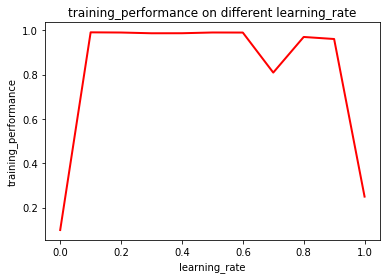

The optimal value for learning_rate is 0.1 with training_performance 0.9904012086685773


In [28]:
plot_hyper(dataset=digits, hyperparameter="learning_rate",feature = "training_performance", low = 0, high = 1, learning_rate=0.4,momentum=0.8,batch_size=21)

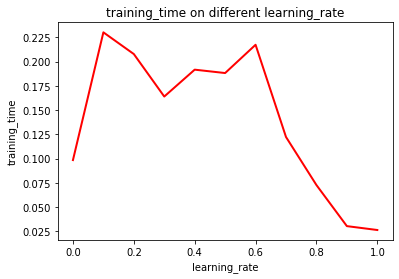

In [29]:
plot_hyper(dataset=digits, hyperparameter="learning_rate",feature = "training_time", low = 0, high = 1, learning_rate=0.4,momentum=0.8,batch_size=21)

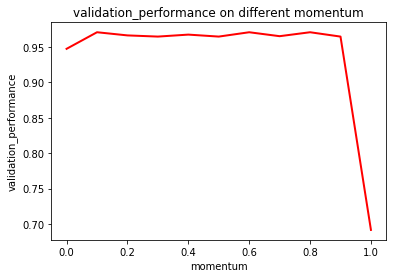

The optimal value for momentum is 0.7999999999999999 with validation_performance 0.9705060352831941


In [61]:
plot_hyper(dataset=digits, hyperparameter="momentum", feature = "validation_performance", low = 0, high = 1, learning_rate=0.4,momentum=0.8,batch_size=21)

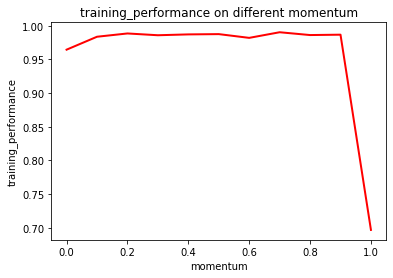

The optimal value for momentum is 0.7 with training_performance 0.9904003375909671


In [31]:
plot_hyper(dataset=digits, hyperparameter="momentum", feature = "training_performance", low = 0, high = 1, learning_rate=0.4,momentum=0.8,batch_size=21)

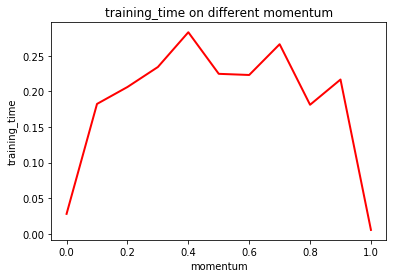

In [32]:
plot_hyper(dataset=digits, hyperparameter="momentum", feature = "training_time", low = 0, high = 1, learning_rate=0.4,momentum=0.8,batch_size=21)

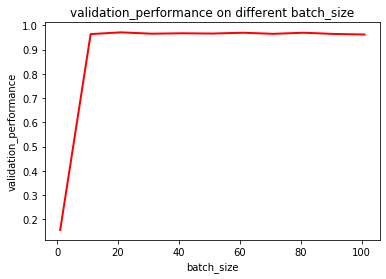

The optimal value for batch_size is 21 with validation_performance 0.9710662333642835


In [33]:
plot_hyper(dataset=digits, hyperparameter="batch_size", feature = "validation_performance", low = 1, high = 101, learning_rate=0.4,momentum=0.8,batch_size=21)

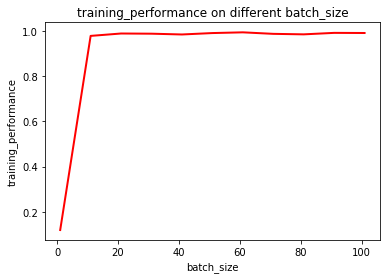

The optimal value for batch_size is 61 with training_performance 0.9940174389737544


In [34]:
plot_hyper(dataset=digits, hyperparameter="batch_size", feature = "training_performance", low = 1, high = 101, learning_rate=0.4,momentum=0.8,batch_size=21)

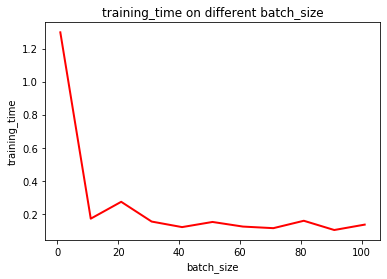

In [35]:
plot_hyper(dataset=digits, hyperparameter="batch_size", feature = "training_time", low = 1, high = 101, learning_rate=0.4,momentum=0.8,batch_size=21)

### Performance vs. Hyperparameters for iris dataset

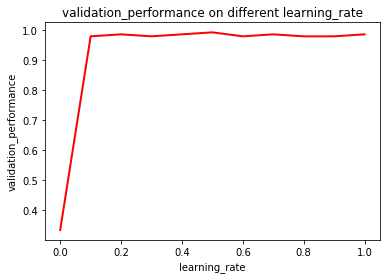

The optimal value for learning_rate is 0.5 with validation_performance 0.9933333333333334


In [65]:
plot_hyper(dataset=iris, hyperparameter="learning_rate",feature = "validation_performance", low = 0, high = 1, learning_rate=0.6,momentum=0.8,batch_size=31)

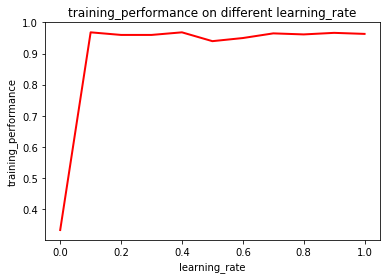

The optimal value for learning_rate is 0.1 with training_performance 0.9683333333333334


In [37]:
plot_hyper(dataset=iris, hyperparameter="learning_rate",feature = "training_performance", low = 0, high = 1, learning_rate=0.6,momentum=0.8,batch_size=31)

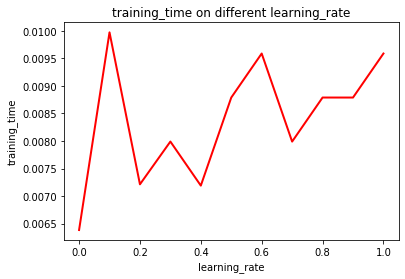

In [38]:
plot_hyper(dataset=iris, hyperparameter="learning_rate",feature = "training_time", low = 0, high = 1, learning_rate=0.6,momentum=0.8,batch_size=31)

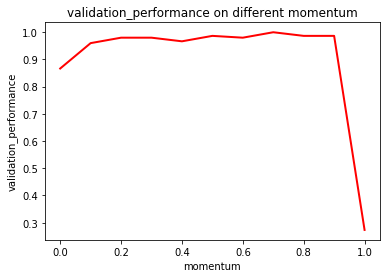

The optimal value for momentum is 0.7 with validation_performance 1.0


In [39]:
plot_hyper(dataset=iris, hyperparameter="momentum", feature = "validation_performance", low = 0, high = 1, learning_rate=0.6,momentum=0.8,batch_size=31)

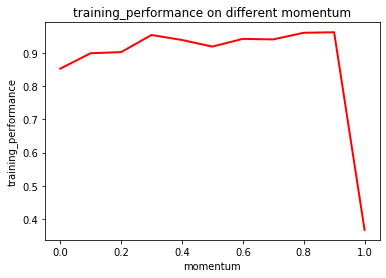

The optimal value for momentum is 0.8999999999999999 with training_performance 0.9633333333333333


In [40]:
plot_hyper(dataset=iris, hyperparameter="momentum", feature = "training_performance", low = 0, high = 1, learning_rate=0.6,momentum=0.8,batch_size=31)

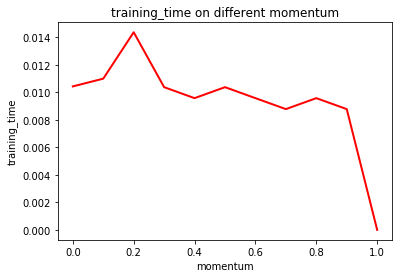

In [41]:
plot_hyper(dataset=iris, hyperparameter="momentum", feature = "training_time", low = 0, high = 1, learning_rate=0.6,momentum=0.8,batch_size=31)

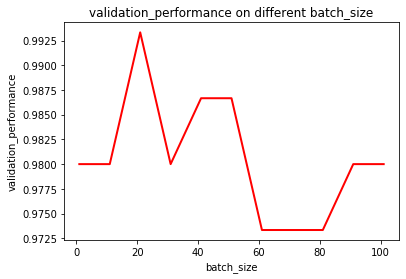

The optimal value for batch_size is 21 with validation_performance 0.9933333333333334


In [73]:
plot_hyper(dataset=iris, hyperparameter="batch_size", feature = "validation_performance", low = 1, high = 101, learning_rate=0.6,momentum=0.8,batch_size=31)

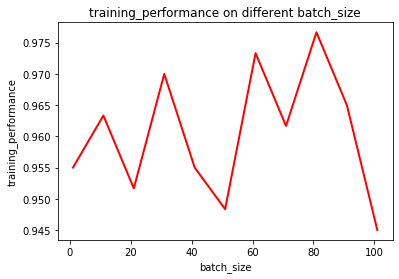

The optimal value for batch_size is 81 with training_performance 0.9766666666666666


In [43]:
plot_hyper(dataset=iris, hyperparameter="batch_size", feature = "training_performance", low = 1, high = 101, learning_rate=0.6,momentum=0.8,batch_size=31)

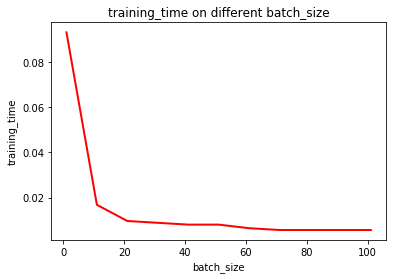

In [44]:
plot_hyper(dataset=iris, hyperparameter="batch_size", feature = "training_time", low = 1, high = 101, learning_rate=0.6,momentum=0.8,batch_size=31)

## Termination condition

In [45]:
# Note that this termination condition for the best validation accuracy is implemented in the Improved Gradient Descent part
# Note that the previous 5-fold cross-validation part also uses this termination condition
# Here is just a simple example to show how to use the termination condition by passing validation dataset
x, y = digits['data'], digits['target']

data = np.hstack((x, y[:,None]))
np.random.shuffle(data)
i = x.shape[0]//3
x_vali = data[:i, :-1]
x = data[i:, :-1]
y_vali = data[:i, -1].astype(int)
y = data[i:, -1].astype(int)

yh_m = SoftmaxRegression().fit(x,y, ImprovedGradientDescent(),x_vali,y_vali).predict(x_vali)
accuracy = (to_classlabel(yh_m) == y_vali).astype(float).mean()
print(accuracy)                                         #performance of this softmax regression algorithm with the best validation accuracy

0.9632721202003339


## Comparison with KNN

### KNN for digits dataset

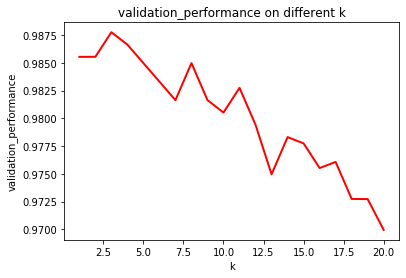

The optimal value for k is 3 with validation_performance 0.9877514701330856


In [46]:
plot_hyper(dataset=digits, hyperparameter="k", feature = "validation_performance", low = 1, high = 20)

In [47]:
print("Performace of KNN with optimal k is " + str(Kcross_validation_test(digits,folds=5,regression_method ="KNN",k=3)))

Performace of KNN with optimal k is 0.987757660167131


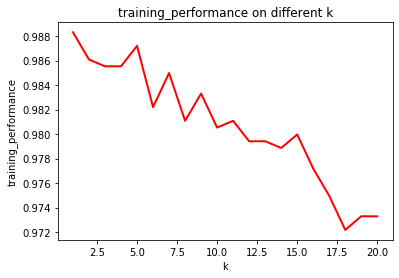

The optimal value for k is 1 with training_performance 0.988310120705664


In [48]:
plot_hyper(dataset=digits, hyperparameter="k", feature = "training_performance", low = 1, high = 20)

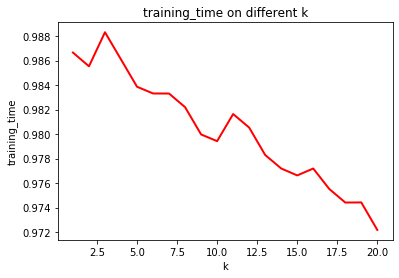

In [49]:
plot_hyper(dataset=digits, hyperparameter="k", feature = "training_time", low = 1, high = 20)

### KNN for iris dataset

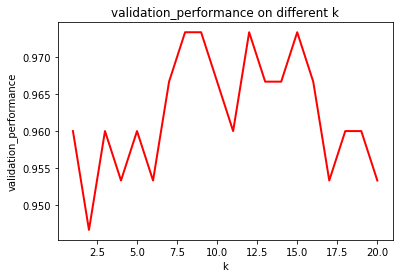

The optimal value for k is 8 with validation_performance 0.9733333333333334


In [50]:
plot_hyper(dataset=iris, hyperparameter="k", feature = "validation_performance", low = 1, high = 20)

In [51]:
print("Performace of KNN with optimal k is " + str(Kcross_validation_test(iris,folds=5,regression_method ="KNN",k=8)))

Performace of KNN with optimal k is 0.9533333333333334


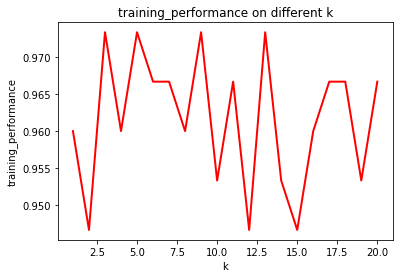

The optimal value for k is 3 with training_performance 0.9733333333333334


In [52]:
plot_hyper(dataset=iris, hyperparameter="k", feature = "training_performance", low = 1, high = 20)

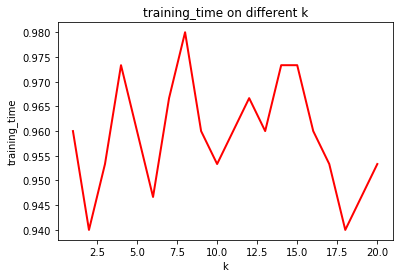

In [53]:
plot_hyper(dataset=iris, hyperparameter="k", feature = "training_time", low = 1, high = 20)

## Investigating L2 regularization

In [14]:
class SoftmaxRegressionL2:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
    
    def fit(self, x, y, optimizer, x_vali=None, y_vali=None, lambdaa=0):
        if x_vali is None:
            x_vali = x
        if y_vali is None:
            y_vali = y
        if x_vali.ndim == 1:
            x_vali = x_vali[:, None]
        if self.add_bias:
            N = x_vali.shape[0]
            x_vali = np.column_stack([x_vali,np.ones(N)])
        
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        C = np.max(y) + 1
        def gradient(x, y, w):                          # define the gradient function
            yh = softmax(np.dot(x, w))                  # predictions
            y = one_hot(y, C)                              # labels with one-hot encoding
            N, D = x.shape
            grad = np.dot(x.T, (yh - y))/N              # divide by N because cost is mean over N points
            grad[1:] += lambdaa * w[1:]                 # adding L2 penalty
            return grad
        w0 = np.zeros((D, np.max(y) + 1))               # initialize the weights to 0, note that the dimension is D*C
        self.w = optimizer.run(gradient, x, y, w0, x_vali, y_vali)      # run the optimizer to get the optimal weights
        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        yh = softmax(np.dot(x,self.w))                  #predict output
        return yh

In [15]:
# Note this is the same example as in the termination condition part, but with L2 regularization
def L2_example(lambdaa):
    x, y = digits['data'], digits['target']

    data = np.hstack((x, y[:,None]))
    np.random.shuffle(data)
    i = x.shape[0]//3
    x_vali = data[:i, :-1]
    x = data[i:, :-1]
    y_vali = data[:i, -1].astype(int)
    y = data[i:, -1].astype(int)

    yh_m = SoftmaxRegressionL2().fit(x,y, ImprovedGradientDescent(),x_vali,y_vali,lambdaa=lambdaa).predict(x_vali)
    accuracy = (to_classlabel(yh_m) == y_vali).astype(float).mean()
    return accuracy

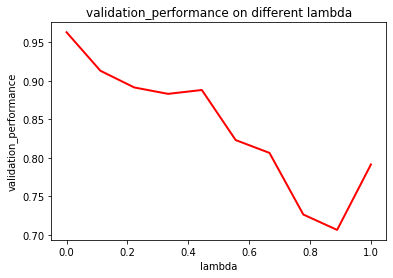

In [20]:
lambdaa_values = np.linspace(0,1,num=10)
accuracy = list()
for lambdaa_value in lambdaa_values:
    accuracy.append(L2_example(lambdaa_value))
plt.plot(lambdaa_values,accuracy, lw = 2, c="r")
plt.title('validation_performance on different lambda')
plt.xlabel('lambda')
plt.ylabel('validation_performance')
plt.show()

In [21]:
optimal_accuracy = max(accuracy)
print(optimal_accuracy)

0.9632721202003339
